# Phase 1: Pre-processing, Aggregation, and EDA for Paris Intra-Muros (2014–2024)

**Thesis Project - Real Estate and Urban Dynamics Analysis**

## Description

This notebook performs comprehensive data preprocessing and exploratory data analysis (EDA) for Paris intra-muros (INSEE code 75056) covering the period 2014–2024. The analysis integrates three key datasets:

- **DVF (Demandes de Valeurs Foncières)**: Real estate transaction data
- **IRIS**: Geographic statistical units for spatial aggregation
- **OSM (OpenStreetMap)**: Points of interest and urban amenities (filtered by amenity types)

The workflow includes:
1. Data loading with strict spatial and temporal filtering
2. Feature engineering at IRIS level
3. Temporal aggregations and change metrics
4. Comprehensive EDA with visualizations
5. Export of processed datasets and figures

## Reproducibility

All random seeds are fixed. Output directories are created automatically. All intermediate and final outputs are saved to `./outputs/` for reproducibility and downstream analysis.

In [2]:
# Set random seed for reproducibility
import random
import numpy as np

RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

print(f"Random seed set to: {RANDOM_SEED}")

Random seed set to: 42


In [3]:
# Display Python version and key package versions
import sys
print(f"Python version: {sys.version}")
print("\nKey package versions:")
!pip list | grep -E "(pandas|geopandas|pyarrow|pyrosm|shapely|matplotlib|contextily|folium|scikit-learn)"

Python version: 3.12.1 (main, Jul 10 2025, 11:57:50) [GCC 13.3.0]

Key package versions:


contextily                1.6.2
folium                    0.20.0
geopandas                 1.1.1
matplotlib                3.10.3
matplotlib-inline         0.1.7
pandas                    2.3.1
pyarrow                   21.0.0
pyrosm                    0.6.2
scikit-learn              1.7.0
shapely                   2.1.2


In [4]:
# Create output directories
import os

output_dirs = [
    "./outputs/figures",
    "./outputs/tables",
    "./outputs/processed"
]

for dir_path in output_dirs:
    os.makedirs(dir_path, exist_ok=True)
    print(f"Created/verified: {dir_path}")

Created/verified: ./outputs/figures
Created/verified: ./outputs/tables
Created/verified: ./outputs/processed


---
## 1. Dependencies and Settings

Import all required libraries and configure display settings, coordinate reference systems, and warning filters.

In [5]:
# Core libraries
import os
import json
import math
import warnings
import textwrap
from datetime import datetime
import time

# Data manipulation
import pandas as pd
import numpy as np
import geopandas as gpd

# Geometry handling
from shapely.geometry import shape, Point
from shapely import wkb

# OSM data processing - TEMPORAL
from ohsome import OhsomeClient

# Visualization
import matplotlib.pyplot as plt
import contextily as cx
import folium

print("All libraries imported successfully.")

All libraries imported successfully.


In [6]:
# Configure display and warning settings
pd.set_option("display.max_columns", 120)
pd.set_option("display.max_rows", 50)
warnings.filterwarnings("ignore")

# Define coordinate reference systems
CRS_LAMBERT93 = "EPSG:2154"  # For area calculations
CRS_WEB_MERCATOR = "EPSG:3857"  # For web tile basemaps
CRS_WGS84 = "EPSG:4326"  # For lat/lon coordinates

# Define study parameters
PARIS_INSEE = "75056"
START_YEAR = 2014
END_YEAR = 2024

print(f"Target CRS: {CRS_LAMBERT93} (Lambert 93)")
print(f"Study area: Paris INSEE {PARIS_INSEE}")
print(f"Study period: {START_YEAR}–{END_YEAR}")

Target CRS: EPSG:2154 (Lambert 93)
Study area: Paris INSEE 75056
Study period: 2014–2024


---
## 2. IRIS Loading and Paris Mask

Load the IRIS geographic units and filter for Paris intra-muros (INSEE 75056). Calculate surface area for each IRIS unit.

In [7]:
# Check if IRIS file exists
import os
print(f"Current working directory: {os.getcwd()}")

# Adjust path based on working directory
if os.getcwd().endswith('notebooks'):
    iris_path = "../data/iris.geojson"
else:
    iris_path = "./data/iris.geojson"

if not os.path.exists(iris_path):
    raise FileNotFoundError(f"IRIS file not found at {iris_path}. Current dir: {os.getcwd()}")

print(f"Loading IRIS data from {iris_path}...")
start_time = time.time()

# Load IRIS geometries
gdf_iris_raw = gpd.read_file(iris_path)

print(f"Loaded {len(gdf_iris_raw):,} IRIS units in {time.time() - start_time:.2f}s")
print(f"\nRaw IRIS columns: {list(gdf_iris_raw.columns)}")
print(f"Original CRS: {gdf_iris_raw.crs}")

Current working directory: /workspaces/thesis/notebooks
Loading IRIS data from ../data/iris.geojson...
Loaded 5,264 IRIS units in 0.44s

Raw IRIS columns: ['dep', 'insee_com', 'nom_com', 'iris', 'code_iris', 'nom_iris', 'typ_iris', 'geo_point_2d', 'id', 'geometry']
Original CRS: EPSG:4326


In [8]:
# Identify commune column (various possible names)
# Note: Paris IRIS data uses department 75 with arrondissement codes 75101-75120
# There is no single 75056 code - Paris is split into 20 arrondissements

# Check if we have department column for Paris filtering
if 'dep' in gdf_iris_raw.columns:
    print(f"Using department column 'dep' for Paris filtering")
    commune_col = 'dep'
    PARIS_FILTER_VALUE = '75'
else:
    # Fallback to commune column
    commune_cols = [col for col in gdf_iris_raw.columns if 'com' in col.lower() and 'insee' in col.lower()]
    if not commune_cols:
        commune_cols = [col for col in gdf_iris_raw.columns if col.upper() in ['INSEE_COM', 'DEPCOM', 'CODGEO']]
    
    if commune_cols:
        commune_col = commune_cols[0]
        PARIS_FILTER_VALUE = PARIS_INSEE
        print(f"Using commune column: '{commune_col}'")
    else:
        raise ValueError("Could not identify department or commune column")

# Standardize column names
if 'insee_com' in gdf_iris_raw.columns and 'INSEE_COM' not in gdf_iris_raw.columns:
    gdf_iris_raw['INSEE_COM'] = gdf_iris_raw['insee_com']

# Find IRIS code column
iris_code_col = [col for col in gdf_iris_raw.columns if 'iris' in col.lower() and 'code' in col.lower()]
if iris_code_col:
    if iris_code_col[0] != 'IRIS':
        gdf_iris_raw['IRIS'] = gdf_iris_raw[iris_code_col[0]]
else:
    print("Warning: IRIS code column not found, using index")
    gdf_iris_raw['IRIS'] = gdf_iris_raw.index.astype(str)

print(f"\nStandardized columns ready")
print(f"Will filter Paris using: {commune_col} == '{PARIS_FILTER_VALUE}'")

Using department column 'dep' for Paris filtering

Standardized columns ready
Will filter Paris using: dep == '75'


In [9]:
# Filter for Paris intra-muros
# Paris is represented by department 75 with 20 arrondissements (75101-75120)
gdf_iris_paris = gdf_iris_raw[gdf_iris_raw[commune_col] == PARIS_FILTER_VALUE].copy()

print(f"Filtered to Paris (dep 75): {len(gdf_iris_paris)} IRIS units")
print(f"Paris arrondissements found: {sorted(gdf_iris_paris['insee_com'].unique()) if 'insee_com' in gdf_iris_paris.columns else 'N/A'}")

if len(gdf_iris_paris) == 0:
    raise ValueError(f"No IRIS units found for Paris. Check filter: {commune_col} == {PARIS_FILTER_VALUE}")

Filtered to Paris (dep 75): 992 IRIS units
Paris arrondissements found: [np.int32(75101), np.int32(75102), np.int32(75103), np.int32(75104), np.int32(75105), np.int32(75106), np.int32(75107), np.int32(75108), np.int32(75109), np.int32(75110), np.int32(75111), np.int32(75112), np.int32(75113), np.int32(75114), np.int32(75115), np.int32(75116), np.int32(75117), np.int32(75118), np.int32(75119), np.int32(75120)]


In [10]:
# Reproject to Lambert 93 for area calculations
if gdf_iris_paris.crs != CRS_LAMBERT93:
    print(f"Reprojecting from {gdf_iris_paris.crs} to {CRS_LAMBERT93}...")
    gdf_iris_paris = gdf_iris_paris.to_crs(CRS_LAMBERT93)

# Calculate surface area in m²
gdf_iris_paris['surface_m2'] = gdf_iris_paris.geometry.area
gdf_iris_paris['surface_km2'] = gdf_iris_paris['surface_m2'] / 1_000_000

print(f"\nSurface statistics:")
print(f"  Total area: {gdf_iris_paris['surface_km2'].sum():.2f} km²")
print(f"  Mean IRIS area: {gdf_iris_paris['surface_m2'].mean():.0f} m²")
print(f"  Min/Max: {gdf_iris_paris['surface_m2'].min():.0f} / {gdf_iris_paris['surface_m2'].max():.0f} m²")

Reprojecting from EPSG:4326 to EPSG:2154...

Surface statistics:
  Total area: 105.43 km²
  Mean IRIS area: 106282 m²
  Min/Max: 8817 / 5418181 m²


In [11]:
# Display sample
print("\nSample of Paris IRIS data:")
display(gdf_iris_paris[['IRIS', 'INSEE_COM', 'surface_m2', 'surface_km2', 'geometry']].head())


Sample of Paris IRIS data:


,IRIS,INSEE_COM,surface_m2,surface_km2,geometry
26,751072601,75107,163425.590001,0.163426,"POLYGON ((649962.5 6862349, 650285.5 6862186.4..."
27,751072603,75107,51062.835000,0.051063,"POLYGON ((649409.8 6862727.9, 649410.1 6862762..."
28,751093605,75109,37918.710001,0.037919,"POLYGON ((651613.9 6864637.7, 651628.9 6864690..."
29,751114108,75111,58223.240000,0.058223,"POLYGON ((653831.9 6863069.7, 653874.1 6863088..."
30,751114404,75111,66905.155000,0.066905,"POLYGON ((654397.6 6861364.1, 654342.7 6861385..."


In [12]:
# Save processed IRIS to GeoParquet
output_iris_path = "./outputs/processed/iris_paris.parquet"
gdf_iris_paris.to_parquet(output_iris_path)

file_size_mb = os.path.getsize(output_iris_path) / (1024 * 1024)
print(f"\nSaved Paris IRIS to {output_iris_path} ({file_size_mb:.2f} MB)")


Saved Paris IRIS to ./outputs/processed/iris_paris.parquet (0.24 MB)


---
## 3. DVF Real Estate Transactions (2014–2024)

Load DVF (Demandes de Valeurs Foncières) real estate transaction data, filter for Paris and the study period, clean outliers, and aggregate by IRIS unit and year.

In [13]:
# Check if DVF file exists
dvf_path = "../data/DVF mutations_d75.gpkg" if os.getcwd().endswith('notebooks') else "./data/DVF mutations_d75.gpkg"

if not os.path.exists(dvf_path):
    raise FileNotFoundError(f"DVF file not found at {dvf_path}")

print(f"Loading DVF data from {dvf_path}...")
start_time = time.time()

# Load DVF - specify layer to avoid warning
gdf_dvf_raw = gpd.read_file(dvf_path, layer='mutation_geompar')

print(f"Loaded {len(gdf_dvf_raw):,} transactions in {time.time() - start_time:.2f}s")
print(f"\nDVF columns: {list(gdf_dvf_raw.columns)}")

Loading DVF data from ../data/DVF mutations_d75.gpkg...
Loaded 457,097 transactions in 17.06s

DVF columns: ['idmutation', 'idmutinvar', 'idopendata', 'idnatmut', 'codservch', 'refdoc', 'datemut', 'anneemut', 'moismut', 'coddep', 'libnatmut', 'vefa', 'valeurfonc', 'nbdispo', 'nblot', 'nbcomm', 'l_codinsee', 'nbsection', 'l_section', 'nbpar', 'l_idpar', 'nbparmut', 'l_idparmut', 'nbsuf', 'sterr', 'nbvolmut', 'nblocmut', 'l_idlocmut', 'nblocmai', 'nblocapt', 'nblocdep', 'nblocact', 'nbapt1pp', 'nbapt2pp', 'nbapt3pp', 'nbapt4pp', 'nbapt5pp', 'nbmai1pp', 'nbmai2pp', 'nbmai3pp', 'nbmai4pp', 'nbmai5pp', 'sbati', 'sbatmai', 'sbatapt', 'sbatact', 'sapt1pp', 'sapt2pp', 'sapt3pp', 'sapt4pp', 'sapt5pp', 'smai1pp', 'smai2pp', 'smai3pp', 'smai4pp', 'smai5pp', 'codtypbien', 'libtypbien', 'geometry']


In [14]:
# Identify key columns based on actual DVF structure
# Actual columns: datemut, valeurfonc, sbati, codtypbien, libtypbien
col_mapping = {}

# Date column
if 'datemut' in gdf_dvf_raw.columns:
    col_mapping['date'] = 'datemut'
else:
    date_cols = [col for col in gdf_dvf_raw.columns if 'date' in col.lower() and 'mut' in col.lower()]
    col_mapping['date'] = date_cols[0] if date_cols else None

# Value column  
if 'valeurfonc' in gdf_dvf_raw.columns:
    col_mapping['value'] = 'valeurfonc'
else:
    value_cols = [col for col in gdf_dvf_raw.columns if 'valeur' in col.lower()]
    col_mapping['value'] = value_cols[0] if value_cols else None

# Surface column (sbati = surface bâtie)
if 'sbati' in gdf_dvf_raw.columns:
    col_mapping['surface'] = 'sbati'
else:
    surface_cols = [col for col in gdf_dvf_raw.columns if 'sbat' in col.lower() or 'surface' in col.lower()]
    col_mapping['surface'] = surface_cols[0] if surface_cols else None

# Type local column
if 'libtypbien' in gdf_dvf_raw.columns:
    col_mapping['type'] = 'libtypbien'
elif 'codtypbien' in gdf_dvf_raw.columns:
    col_mapping['type'] = 'codtypbien'
else:
    type_cols = [col for col in gdf_dvf_raw.columns if 'type' in col.lower() or 'bien' in col.lower()]
    col_mapping['type'] = type_cols[0] if type_cols else None

# Number of rooms - not directly available in this DVF format
col_mapping['rooms'] = None

# Nature mutation
if 'libnatmut' in gdf_dvf_raw.columns:
    col_mapping['nature'] = 'libnatmut'
else:
    nature_cols = [col for col in gdf_dvf_raw.columns if 'nat' in col.lower() and 'mut' in col.lower()]
    col_mapping['nature'] = nature_cols[0] if nature_cols else None

print("Column mapping:")
for key, val in col_mapping.items():
    print(f"  {key}: {val}")

Column mapping:
  date: datemut
  value: valeurfonc
  surface: sbati
  type: libtypbien
  rooms: None
  nature: libnatmut


In [15]:
# Rename columns for consistency
rename_dict = {}
if col_mapping['date']:
    rename_dict[col_mapping['date']] = 'date_mutation'
if col_mapping['value']:
    rename_dict[col_mapping['value']] = 'valeur_fonciere'
if col_mapping['surface']:
    rename_dict[col_mapping['surface']] = 'surface_reelle_batie'
if col_mapping['type']:
    rename_dict[col_mapping['type']] = 'type_local'
if col_mapping['rooms']:
    rename_dict[col_mapping['rooms']] = 'nombre_pieces'
if col_mapping['nature']:
    rename_dict[col_mapping['nature']] = 'nature_mutation'

gdf_dvf = gdf_dvf_raw.rename(columns=rename_dict).copy()

# Keep only necessary columns
keep_cols = ['date_mutation', 'valeur_fonciere', 'surface_reelle_batie', 'type_local', 
             'nombre_pieces', 'nature_mutation', 'geometry']
keep_cols = [col for col in keep_cols if col in gdf_dvf.columns]
gdf_dvf = gdf_dvf[keep_cols]

print(f"\nRetained columns: {list(gdf_dvf.columns)}")


Retained columns: ['date_mutation', 'valeur_fonciere', 'surface_reelle_batie', 'type_local', 'nature_mutation', 'geometry']


In [16]:
# Convert date to year
gdf_dvf['date_mutation'] = pd.to_datetime(gdf_dvf['date_mutation'], errors='coerce')
gdf_dvf['year'] = gdf_dvf['date_mutation'].dt.year

print(f"Date conversion complete. Year range: {gdf_dvf['year'].min()}–{gdf_dvf['year'].max()}")

Date conversion complete. Year range: 2014–2024


In [17]:
# Filter for study period (2014-2024)
gdf_dvf = gdf_dvf[(gdf_dvf['year'] >= START_YEAR) & (gdf_dvf['year'] <= END_YEAR)].copy()

print(f"Filtered to {START_YEAR}–{END_YEAR}: {len(gdf_dvf):,} transactions")

# Ensure numeric types
gdf_dvf['valeur_fonciere'] = pd.to_numeric(gdf_dvf['valeur_fonciere'], errors='coerce')
gdf_dvf['surface_reelle_batie'] = pd.to_numeric(gdf_dvf['surface_reelle_batie'], errors='coerce')

Filtered to 2014–2024: 457,097 transactions


In [18]:
# Calculate price per m² and filter outliers
gdf_dvf['prix_m2'] = gdf_dvf['valeur_fonciere'] / gdf_dvf['surface_reelle_batie']

# Remove outliers and invalid values
before_count = len(gdf_dvf)

gdf_dvf = gdf_dvf[
    (gdf_dvf['prix_m2'] >= 10) & 
    (gdf_dvf['prix_m2'] <= 40000) &
    (gdf_dvf['surface_reelle_batie'] > 9) &
    (gdf_dvf['valeur_fonciere'] > 0)
].copy()

after_count = len(gdf_dvf)
removed = before_count - after_count

print(f"\nOutlier filtering:")
print(f"  Removed {removed:,} transactions ({removed/before_count*100:.1f}%)")
print(f"  Retained {after_count:,} valid transactions")
print(f"\nPrice per m² statistics:")
print(f"  Mean: €{gdf_dvf['prix_m2'].mean():.0f}/m²")
print(f"  Median: €{gdf_dvf['prix_m2'].median():.0f}/m²")
print(f"  P10-P90: €{gdf_dvf['prix_m2'].quantile(0.1):.0f} - €{gdf_dvf['prix_m2'].quantile(0.9):.0f}")


Outlier filtering:
  Removed 71,798 transactions (15.7%)
  Retained 385,299 valid transactions

Price per m² statistics:
  Mean: €9388/m²
  Median: €9300/m²
  P10-P90: €5125 - €13400


In [19]:
# Reproject to Lambert 93 for spatial join
if gdf_dvf.crs != CRS_LAMBERT93:
    print(f"Reprojecting DVF from {gdf_dvf.crs} to {CRS_LAMBERT93}...")
    gdf_dvf = gdf_dvf.to_crs(CRS_LAMBERT93)

# Spatial join with IRIS
print(f"\nPerforming spatial join with IRIS...")
start_time = time.time()

gdf_dvf = gpd.sjoin(
    gdf_dvf,
    gdf_iris_paris[['IRIS', 'geometry']],
    how='inner',
    predicate='intersects'
)

print(f"Spatial join complete in {time.time() - start_time:.2f}s")
print(f"Transactions matched to IRIS: {len(gdf_dvf):,}")
print(f"Unique IRIS units with transactions: {gdf_dvf['IRIS'].nunique()}")


Performing spatial join with IRIS...


Spatial join complete in 2.81s
Transactions matched to IRIS: 388,728
Unique IRIS units with transactions: 917


In [20]:
# Calculate property type percentages
def calculate_type_shares(group):
    total = len(group)
    if total == 0:
        return pd.Series({'pct_appartement': 0, 'pct_maison': 0})
    
    type_col = 'type_local' if 'type_local' in group.columns else None
    if type_col is None:
        return pd.Series({'pct_appartement': 0, 'pct_maison': 0})
    
    pct_appt = (group[type_col].str.lower().str.contains('appart', na=False).sum() / total) * 100
    pct_maison = (group[type_col].str.lower().str.contains('maison', na=False).sum() / total) * 100
    
    return pd.Series({'pct_appartement': pct_appt, 'pct_maison': pct_maison})

print("Aggregating DVF by IRIS and year...")
start_time = time.time()

# Aggregate by IRIS and year
dvf_agg = gdf_dvf.groupby(['IRIS', 'year']).agg(
    count_sales=('valeur_fonciere', 'count'),
    median_price_m2=('prix_m2', 'median'),
    p90_price_m2=('prix_m2', lambda x: x.quantile(0.9)),
    median_surface=('surface_reelle_batie', 'median'),
    total_value=('valeur_fonciere', 'sum')
).reset_index()

# Calculate type percentages separately
if 'type_local' in gdf_dvf.columns:
    type_shares = gdf_dvf.groupby(['IRIS', 'year']).apply(calculate_type_shares).reset_index()
    dvf_agg = dvf_agg.merge(type_shares, on=['IRIS', 'year'], how='left')

print(f"Aggregation complete in {time.time() - start_time:.2f}s")
print(f"Aggregated records: {len(dvf_agg):,} (IRIS × year combinations)")
print(f"\nSample of aggregated DVF data:")
display(dvf_agg.head(10))

Aggregating DVF by IRIS and year...
Aggregation complete in 10.87s
Aggregated records: 9,853 (IRIS × year combinations)

Sample of aggregated DVF data:


,IRIS,year,count_sales,median_price_m2,p90_price_m2,median_surface,total_value,pct_appartement,pct_maison
0,751010101,2014,22,8994.307400,11163.354851,75.5,18979412.00,77.272727,0.0
1,751010101,2015,24,10471.175166,12439.319549,64.0,16161396.00,100.000000,0.0
2,751010101,2016,15,9943.820225,13266.165414,59.0,11469690.00,86.666667,0.0
3,751010101,2017,19,10763.888889,12961.165049,58.0,40495350.00,73.684211,0.0
4,751010101,2018,16,11001.165254,14159.355556,35.5,8074358.77,81.250000,0.0
5,751010101,2019,16,11764.666667,16291.047745,37.0,8424690.00,93.750000,0.0
6,751010101,2020,12,13075.423729,14519.480519,62.0,9712000.00,75.000000,0.0
7,751010101,2021,18,11991.071429,16185.854038,110.0,39841418.00,72.222222,0.0
8,751010101,2022,12,13515.151515,17203.307692,41.0,10147791.00,100.000000,0.0
9,751010101,2023,18,12650.809717,16133.333333,42.5,10532287.00,77.777778,0.0


In [21]:
# Save aggregated DVF
output_dvf_path = "./outputs/tables/dvf_iris_year.parquet"
dvf_agg.to_parquet(output_dvf_path, index=False)

file_size_mb = os.path.getsize(output_dvf_path) / (1024 * 1024)
print(f"\nSaved aggregated DVF to {output_dvf_path} ({file_size_mb:.2f} MB)")


Saved aggregated DVF to ./outputs/tables/dvf_iris_year.parquet (0.28 MB)


### DVF Visualizations

Generate distribution plots and spatial maps of real estate prices.

Saved price distribution plot to ./outputs/figures/dvf_price_distributions.png


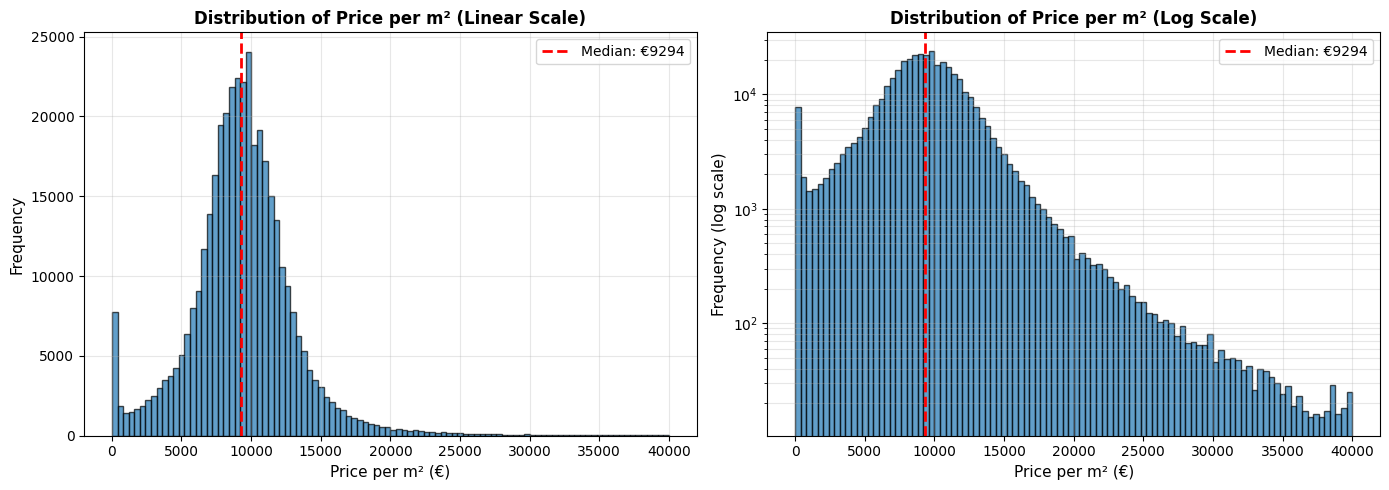

In [22]:
# Price distribution plots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Linear scale
axes[0].hist(gdf_dvf['prix_m2'], bins=100, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Price per m² (€)', fontsize=11)
axes[0].set_ylabel('Frequency', fontsize=11)
axes[0].set_title('Distribution of Price per m² (Linear Scale)', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].axvline(gdf_dvf['prix_m2'].median(), color='red', linestyle='--', linewidth=2, label=f"Median: €{gdf_dvf['prix_m2'].median():.0f}")
axes[0].legend()

# Log scale
axes[1].hist(gdf_dvf['prix_m2'], bins=100, edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Price per m² (€)', fontsize=11)
axes[1].set_ylabel('Frequency (log scale)', fontsize=11)
axes[1].set_title('Distribution of Price per m² (Log Scale)', fontsize=12, fontweight='bold')
axes[1].set_yscale('log')
axes[1].grid(True, alpha=0.3, which='both')
axes[1].axvline(gdf_dvf['prix_m2'].median(), color='red', linestyle='--', linewidth=2, label=f"Median: €{gdf_dvf['prix_m2'].median():.0f}")
axes[1].legend()

plt.tight_layout()
fig_path = "./outputs/figures/dvf_price_distributions.png"
plt.savefig(fig_path, dpi=300, bbox_inches='tight')
print(f"Saved price distribution plot to {fig_path}")
plt.show()

Saved map for 2014 to ./outputs/figures/dvf_median_price_map_2014.png


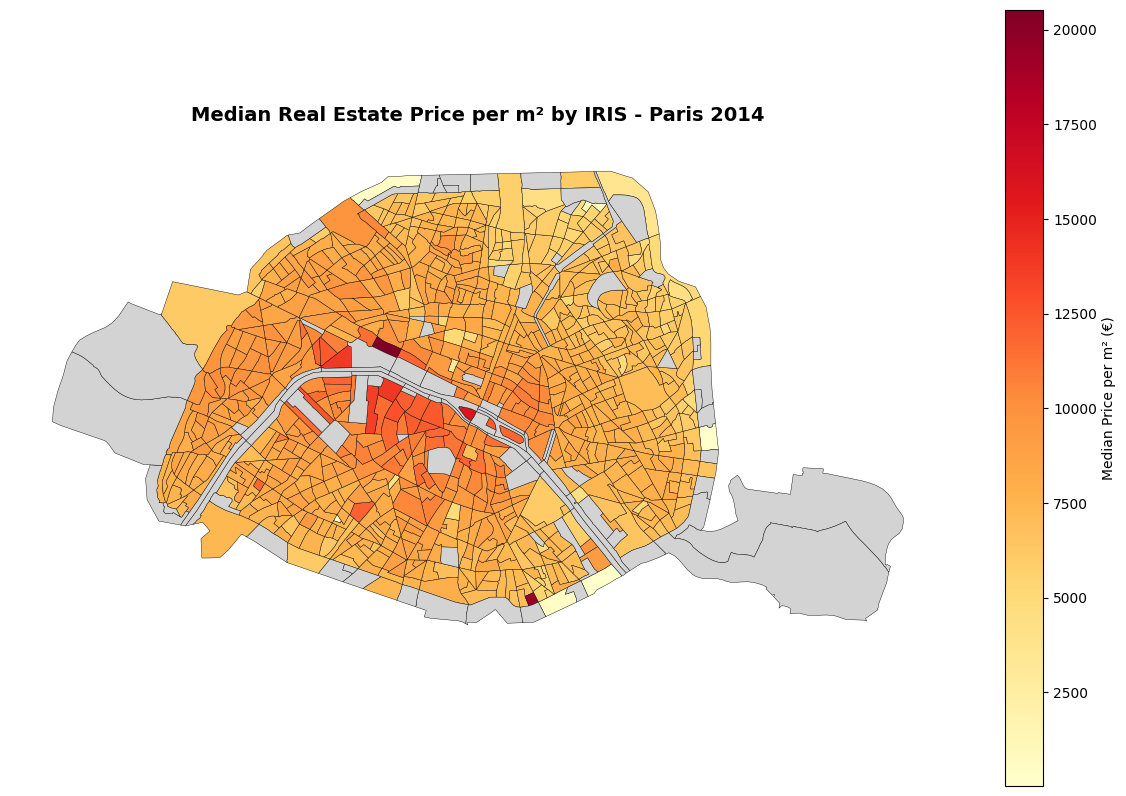

Saved map for 2018 to ./outputs/figures/dvf_median_price_map_2018.png


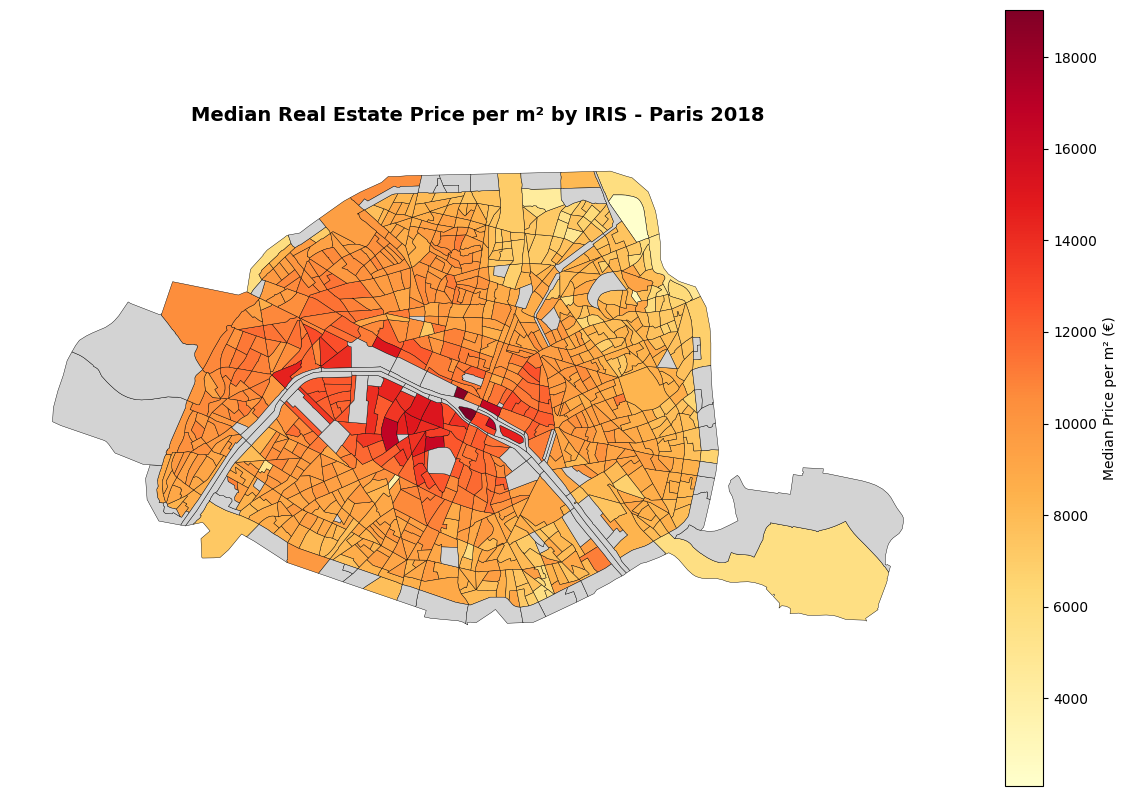

Saved map for 2024 to ./outputs/figures/dvf_median_price_map_2024.png


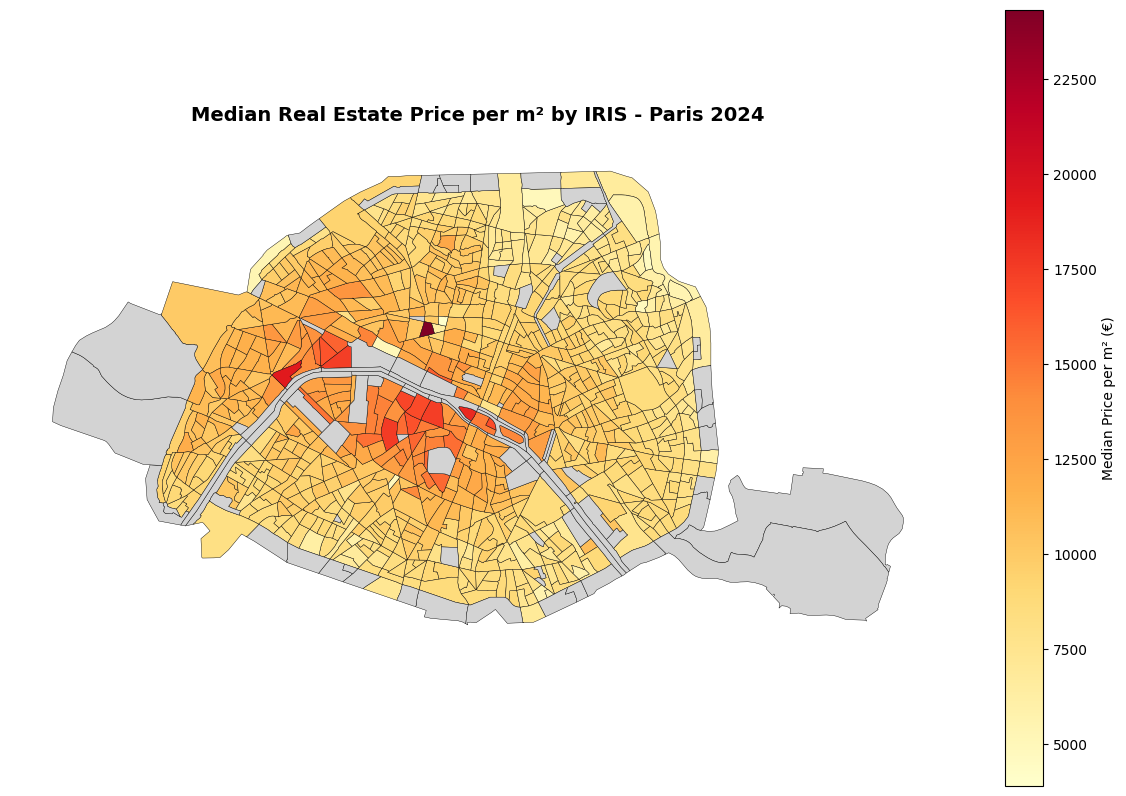

In [23]:
# Choropleth maps for selected years
map_years = [2014, 2018, 2024]

for map_year in map_years:
    # Get data for this year
    year_data = dvf_agg[dvf_agg['year'] == map_year][['IRIS', 'median_price_m2']]
    
    # Merge with IRIS geometries
    gdf_map = gdf_iris_paris.merge(year_data, on='IRIS', how='left')
    
    # Create figure
    fig, ax = plt.subplots(1, 1, figsize=(12, 10))
    
    # Plot
    gdf_map.plot(
        column='median_price_m2',
        ax=ax,
        legend=True,
        cmap='YlOrRd',
        edgecolor='black',
        linewidth=0.3,
        missing_kwds={'color': 'lightgrey', 'label': 'No data'},
        legend_kwds={'label': 'Median Price per m² (€)', 'shrink': 0.8}
    )
    
    ax.set_title(f'Median Real Estate Price per m² by IRIS - Paris {map_year}', 
                 fontsize=14, fontweight='bold', pad=20)
    ax.axis('off')
    
    plt.tight_layout()
    fig_path = f"./outputs/figures/dvf_median_price_map_{map_year}.png"
    plt.savefig(fig_path, dpi=300, bbox_inches='tight')
    print(f"Saved map for {map_year} to {fig_path}")
    plt.show()

---
## 5. OSM Points of Interest and Amenities (Temporal Data via ohsome API)

Extract temporal OSM amenity data from 2014-2024 using the ohsome API, which provides time-series data for urban amenities including cafes, restaurants, cultural venues, transport infrastructure, and retail establishments. This replaces the static pyrosm snapshot with dynamic temporal data aligned with the DVF time series.

In [25]:
print("="*80)
print("SECTION 5: OSM AMENITIES (Temporal Data via ohsome API)")
print("="*80)
print("\nInitializing ohsome API client...")

from ohsome import OhsomeClient
client = OhsomeClient()

# Check API info
print(f"ohsome API base URL: {client.base_api_url}")
print(f"Data coverage: {client.start_timestamp} to {client.end_timestamp}")

SECTION 5: OSM AMENITIES (Temporal Data via ohsome API)

Initializing ohsome API client...
ohsome API base URL: https://api.ohsome.org/v1/
Data coverage: 2007-10-08 00:00:00 to 2025-10-01 12:00:00


In [34]:
# Define amenity categories to extract
amenity_categories = {
    'food_drink': ['cafe', 'restaurant', 'bar', 'pub', 'fast_food', 'bistro'],
    'culture': ['theatre', 'cinema', 'arts_centre', 'gallery', 'museum', 'library'],
    'transport': ['bicycle_rental', 'bicycle_parking', 'bus_station', 'ferry_terminal'],
    'recreation': ['playground', 'sports_centre', 'gym', 'fitness_centre'],
    'retail': ['marketplace', 'supermarket']
}

print("Amenity categories defined:")
for cat, amenities in amenity_categories.items():
    print(f"  {cat}: {len(amenities)} types")

Amenity categories defined:
  food_drink: 6 types
  culture: 6 types
  transport: 4 types
  recreation: 4 types
  retail: 2 types


In [35]:
import time

print("\nExtracting temporal POI data from ohsome API...")
print(f"Time range: {START_YEAR}-01-01 to {END_YEAR}-12-31 (yearly intervals)")

# Prepare Paris IRIS boundaries in WGS84 for ohsome
gdf_iris_wgs84 = gdf_iris_paris[['IRIS', 'geometry']].to_crs("EPSG:4326")

# CRITICAL: ohsome preserves the GeoDataFrame index as boundary IDs
# Create mapping from dataframe index to IRIS codes
iris_id_mapping = gdf_iris_wgs84['IRIS'].to_dict()  # Maps index -> IRIS code

print(f"Processing {len(gdf_iris_wgs84)} IRIS units...")
print(f"Sample IRIS codes: {list(gdf_iris_wgs84['IRIS'].head(3))}")
print(f"Sample dataframe indices: {list(gdf_iris_wgs84.index[:3])}")

# Define time parameter (yearly from 2014 to 2024)
time_param = f"{START_YEAR}-01-01/{END_YEAR}-12-31/P1Y"

# Store results for each category
poi_temporal_data = []

for category, amenity_list in amenity_categories.items():
    print(f"\nQuerying {category}...")
    start_time = time.time()
    
    # Create filter string for this category
    filter_str = " or ".join([f"amenity={a}" for a in amenity_list])
    
    try:
        # Query ohsome API
        response = client.elements.count.groupByBoundary.post(
            bpolys=gdf_iris_wgs84,
            filter=filter_str,
            time=time_param
        )
        
        # Convert to dataframe
        df_response = response.as_dataframe()
        
        # Reset index to get boundary and timestamp as columns
        df_response = df_response.reset_index()
        
        # Check actual column names
        if 'timestamp' in df_response.columns and 'boundary' in df_response.columns:
            # Data is already in long format
            df_long = df_response.copy()
        else:
            # Data might be in wide format - melt it
            id_col = df_response.columns[0]
            timestamp_cols = [col for col in df_response.columns if col != id_col]
            
            df_long = df_response.melt(
                id_vars=[id_col],
                value_vars=timestamp_cols,
                var_name='timestamp',
                value_name='value'
            )
            df_long = df_long.rename(columns={id_col: 'boundary'})
        
        # Get the value column
        value_col = 'value' if 'value' in df_long.columns else [c for c in df_long.columns if c not in ['boundary', 'timestamp']][0]
        
        # CRITICAL FIX: ohsome uses GeoDataFrame index as boundary ID
        # Map these indices back to IRIS codes
        df_long['boundary'] = df_long['boundary'].astype(int)
        df_long['IRIS'] = df_long['boundary'].map(iris_id_mapping)
        
        # Check for unmapped boundaries
        unmapped = df_long['IRIS'].isna().sum()
        if unmapped > 0:
            print(f"  WARNING: {unmapped} boundaries could not be mapped to IRIS codes")
            print(f"  Sample unmapped boundary IDs: {df_long[df_long['IRIS'].isna()]['boundary'].unique()[:5].tolist()}")
        
        # Extract year from timestamp
        df_long['year'] = pd.to_datetime(df_long['timestamp'], errors='coerce').dt.year
        df_long['category'] = category
        df_long = df_long.rename(columns={value_col: 'count'})
        
        # Only keep records with valid IRIS codes
        df_long_clean = df_long[['IRIS', 'year', 'category', 'count']].dropna(subset=['IRIS'])
        poi_temporal_data.append(df_long_clean)
        
        print(f"  {category}: {len(df_long_clean)} valid records extracted in {time.time() - start_time:.2f}s")
        
    except Exception as e:
        print(f"  Error querying {category}: {e}")
        import traceback
        print(f"  Traceback: {traceback.format_exc()}")
        continue

# Combine all categories
if poi_temporal_data:
    df_pois_temporal = pd.concat(poi_temporal_data, ignore_index=True)
    print(f"\nTotal POI temporal records: {len(df_pois_temporal):,}")
    print(f"Unique IRIS codes: {df_pois_temporal['IRIS'].nunique()}")
    print(f"\nSample:")
    display(df_pois_temporal.head(20))
    
    # Validation check
    print(f"\nValidation:")
    print(f"  Expected IRIS codes in Paris: {len(gdf_iris_paris)}")
    print(f"  IRIS codes with POI data: {df_pois_temporal['IRIS'].nunique()}")
    print(f"  Sample IRIS codes in data: {list(df_pois_temporal['IRIS'].unique()[:5])}")
else:
    print("\nError: No POI data extracted")
    df_pois_temporal = pd.DataFrame()


Extracting temporal POI data from ohsome API...
Time range: 2014-01-01 to 2024-12-31 (yearly intervals)
Processing 992 IRIS units...
Sample IRIS codes: ['751072601', '751072603', '751093605']
Sample dataframe indices: [26, 27, 28]

Querying food_drink...
  food_drink: 10912 valid records extracted in 11.11s

Querying culture...
  culture: 10912 valid records extracted in 11.09s

Querying transport...
  transport: 10912 valid records extracted in 13.71s

Querying recreation...
  recreation: 10912 valid records extracted in 21.40s

Querying retail...
  retail: 10912 valid records extracted in 10.78s

Total POI temporal records: 54,560
Unique IRIS codes: 992

Sample:


,IRIS,year,category,count
0,751062305,2014,food_drink,11.0
1,751062305,2015,food_drink,11.0
2,751062305,2016,food_drink,14.0
3,751062305,2017,food_drink,17.0
4,751062305,2018,food_drink,17.0
5,751062305,2019,food_drink,17.0
6,751062305,2020,food_drink,17.0
7,751062305,2021,food_drink,18.0
8,751062305,2022,food_drink,24.0
9,751062305,2023,food_drink,28.0



Validation:
  Expected IRIS codes in Paris: 992
  IRIS codes with POI data: 992
  Sample IRIS codes in data: ['751062305', '751083206', '751114205', '751135024', '751135030']


In [36]:
if len(df_pois_temporal) > 0:
    print("Pivoting POI data to wide format...")
    
    # Pivot to have categories as columns
    poi_wide = df_pois_temporal.pivot_table(
        index=['IRIS', 'year'],
        columns='category',
        values='count',
        fill_value=0
    ).reset_index()
    
    # Flatten column names
    poi_wide.columns.name = None
    
    # Calculate total amenities
    category_cols = [col for col in poi_wide.columns if col not in ['IRIS', 'year']]
    poi_wide['total_amenities'] = poi_wide[category_cols].sum(axis=1)
    
    # Merge with IRIS to get surface area for density calculations
    poi_features_temporal = poi_wide.merge(
        gdf_iris_paris[['IRIS', 'surface_km2']],
        on='IRIS',
        how='left'
    )
    
    # Calculate densities
    for col in category_cols + ['total_amenities']:
        poi_features_temporal[f'{col}_density_km2'] = poi_features_temporal[col] / poi_features_temporal['surface_km2']
    
    print(f"\nTemporal POI features: {len(poi_features_temporal):,} records (IRIS × year)")
    print(f"Columns: {list(poi_features_temporal.columns)}")
    print(f"\nSample:")
    display(poi_features_temporal.head(10))
    
    # Save
    output_path = "./outputs/tables/osm_iris_year_temporal.parquet"
    poi_features_temporal.to_parquet(output_path, index=False)
    file_size_mb = os.path.getsize(output_path) / (1024 * 1024)
    print(f"\nSaved temporal POI features to {output_path} ({file_size_mb:.2f} MB)")

Pivoting POI data to wide format...

Temporal POI features: 10,912 records (IRIS × year)
Columns: ['IRIS', 'year', 'culture', 'food_drink', 'recreation', 'retail', 'transport', 'total_amenities', 'surface_km2', 'culture_density_km2', 'food_drink_density_km2', 'recreation_density_km2', 'retail_density_km2', 'transport_density_km2', 'total_amenities_density_km2']

Sample:


,IRIS,year,culture,food_drink,recreation,retail,transport,total_amenities,surface_km2,culture_density_km2,food_drink_density_km2,recreation_density_km2,retail_density_km2,transport_density_km2,total_amenities_density_km2
0,751010101,2014,1.0,11.0,0.0,0.0,1.0,13.0,0.06364,15.713303,172.846329,0.0,0.0,15.713303,204.272934
1,751010101,2015,1.0,11.0,0.0,0.0,1.0,13.0,0.06364,15.713303,172.846329,0.0,0.0,15.713303,204.272934
2,751010101,2016,1.0,23.0,0.0,0.0,2.0,26.0,0.06364,15.713303,361.405960,0.0,0.0,31.426605,408.545868
3,751010101,2017,1.0,22.0,0.0,0.0,2.0,25.0,0.06364,15.713303,345.692658,0.0,0.0,31.426605,392.832566
4,751010101,2018,1.0,27.0,0.0,0.0,2.0,30.0,0.06364,15.713303,424.259171,0.0,0.0,31.426605,471.399079
5,751010101,2019,2.0,24.0,0.0,0.0,2.0,28.0,0.06364,31.426605,377.119263,0.0,0.0,31.426605,439.972473
6,751010101,2020,2.0,24.0,0.0,0.0,5.0,31.0,0.06364,31.426605,377.119263,0.0,0.0,78.566513,487.112381
7,751010101,2021,2.0,24.0,0.0,0.0,4.0,30.0,0.06364,31.426605,377.119263,0.0,0.0,62.853210,471.399079
8,751010101,2022,2.0,24.0,0.0,0.0,16.0,42.0,0.06364,31.426605,377.119263,0.0,0.0,251.412842,659.958710
9,751010101,2023,2.0,28.0,0.0,0.0,16.0,46.0,0.06364,31.426605,439.972473,0.0,0.0,251.412842,722.811921



Saved temporal POI features to ./outputs/tables/osm_iris_year_temporal.parquet (0.24 MB)


In [37]:
print("="*80)
print("TEMPORAL POI ANALYSIS")
print("="*80)

if len(poi_features_temporal) > 0:
    # Calculate growth rates by category
    growth_analysis = []
    
    for cat in category_cols:
        start_val = poi_features_temporal[poi_features_temporal['year'] == START_YEAR][cat].sum()
        end_val = poi_features_temporal[poi_features_temporal['year'] == END_YEAR][cat].sum()
        growth_pct = ((end_val - start_val) / start_val * 100) if start_val > 0 else 0
        
        growth_analysis.append({
            'category': cat,
            'start_count': start_val,
            'end_count': end_val,
            'growth_pct': growth_pct
        })
    
    df_growth = pd.DataFrame(growth_analysis)
    print(f"\nAmenity Growth Analysis ({START_YEAR}–{END_YEAR}):")
    display(df_growth.sort_values('growth_pct', ascending=False))
    
    # Identify IRIS with highest amenity growth
    iris_growth = poi_features_temporal.groupby('IRIS').agg({
        'total_amenities': lambda x: x.iloc[-1] - x.iloc[0] if len(x) >= 2 else 0
    }).reset_index()
    iris_growth.columns = ['IRIS', 'amenity_change']
    iris_growth = iris_growth.sort_values('amenity_change', ascending=False)
    
    print(f"\nTop 10 IRIS by Amenity Growth:")
    display(iris_growth.head(10))

TEMPORAL POI ANALYSIS

Amenity Growth Analysis (2014–2024):


,category,start_count,end_count,growth_pct
4,transport,2305.0,10348.0,348.937093
1,food_drink,4665.0,14870.0,218.756699
0,culture,375.0,633.0,68.800000
3,retail,102.0,108.0,5.882353
2,recreation,3.0,0.0,-100.000000



Top 10 IRIS by Amenity Growth:


,IRIS,amenity_change
12,751010301,112.0
21,751020602,96.0
54,751041401,94.0
228,751103704,88.0
211,751093501,87.0
6,751010201,86.0
400,751134908,85.0
100,751062101,83.0
212,751093502,82.0
106,751062203,80.0



Creating temporal POI visualizations...
Saved time series to ./outputs/figures/osm_amenities_timeseries.png


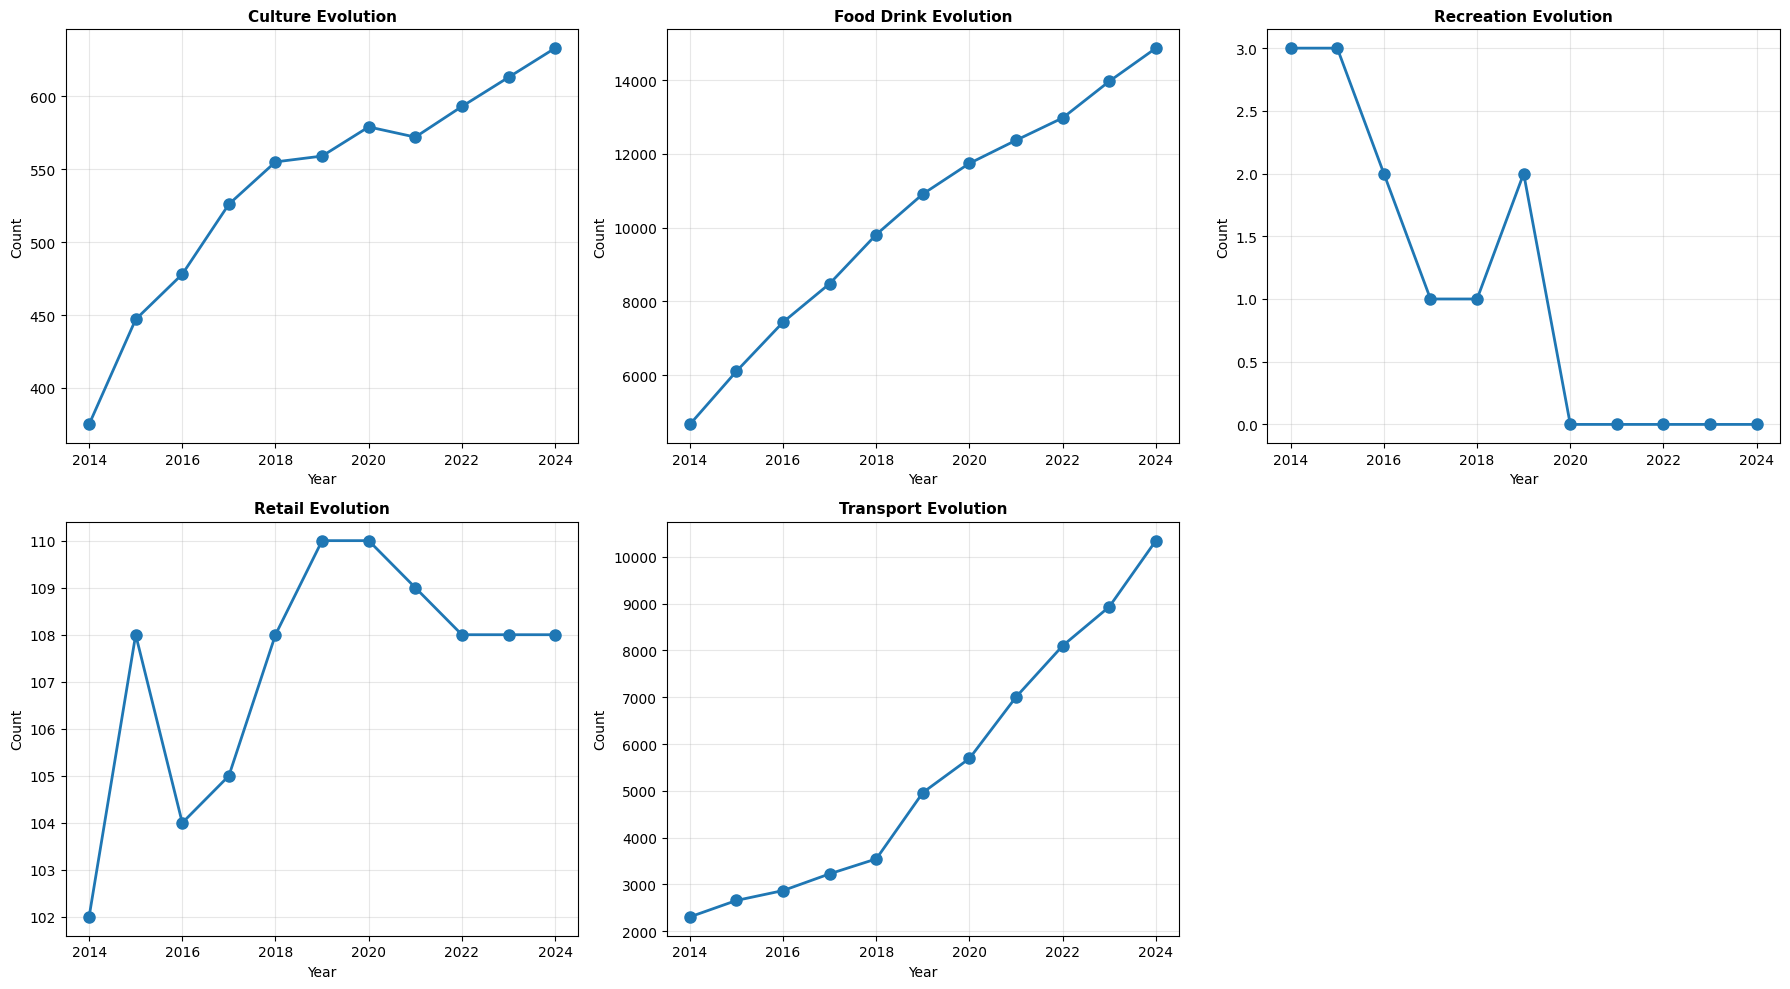

In [38]:
if len(poi_features_temporal) > 0:
    print("\nCreating temporal POI visualizations...")
    
    # Aggregate by year across all IRIS
    yearly_pois = poi_features_temporal.groupby('year')[category_cols].sum().reset_index()
    
    # Time series plot
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()
    
    for idx, cat in enumerate(category_cols):
        ax = axes[idx]
        ax.plot(yearly_pois['year'], yearly_pois[cat], marker='o', linewidth=2, markersize=8)
        ax.set_xlabel('Year', fontsize=10)
        ax.set_ylabel('Count', fontsize=10)
        ax.set_title(f'{cat.replace("_", " ").title()} Evolution', fontsize=11, fontweight='bold')
        ax.grid(True, alpha=0.3)
    
    # Hide extra subplot if needed
    if len(category_cols) < len(axes):
        axes[-1].axis('off')
    
    plt.tight_layout()
    fig_path = "./outputs/figures/osm_amenities_timeseries.png"
    plt.savefig(fig_path, dpi=300, bbox_inches='tight')
    print(f"Saved time series to {fig_path}")
    plt.show()

Saved map for 2014 to ./outputs/figures/osm_amenities_density_map_2014.png


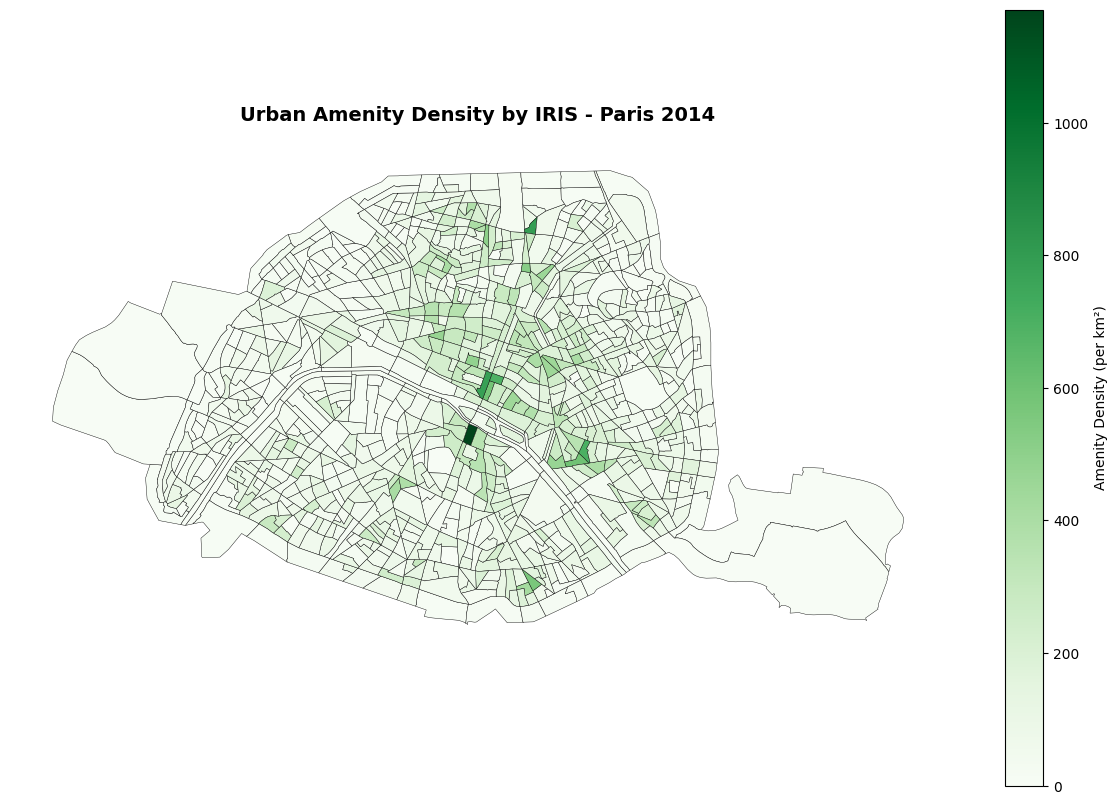

Saved map for 2018 to ./outputs/figures/osm_amenities_density_map_2018.png


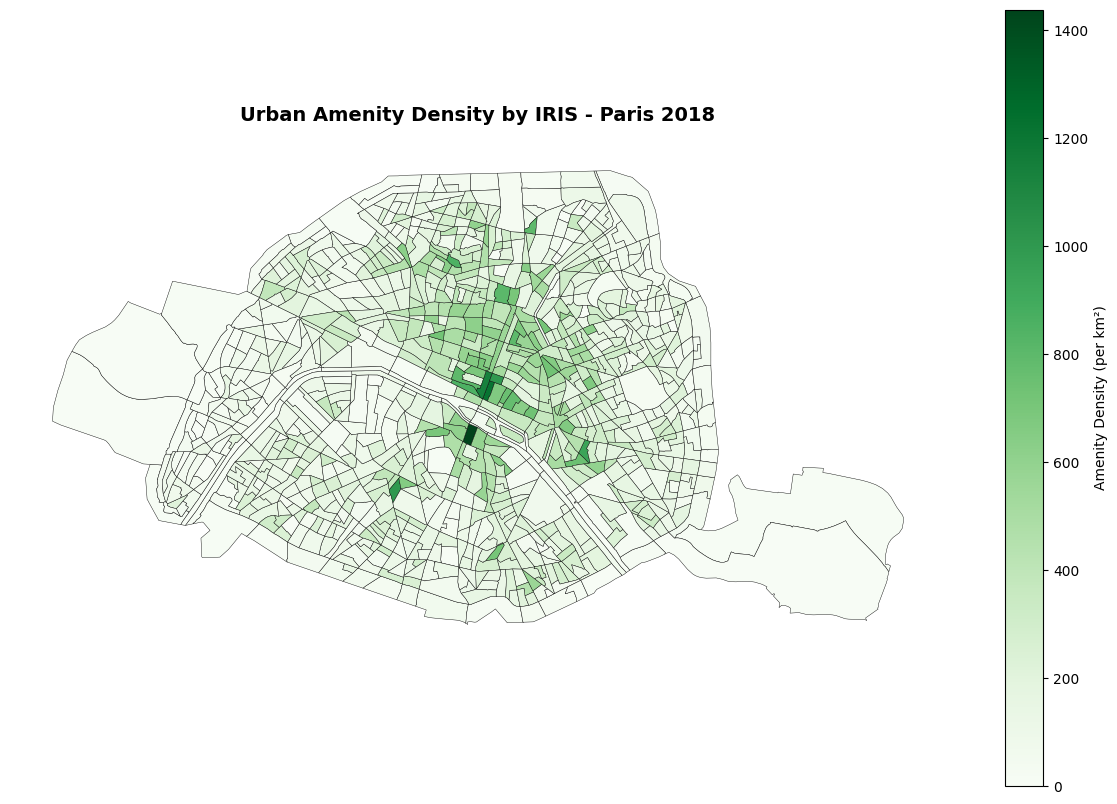

Saved map for 2024 to ./outputs/figures/osm_amenities_density_map_2024.png


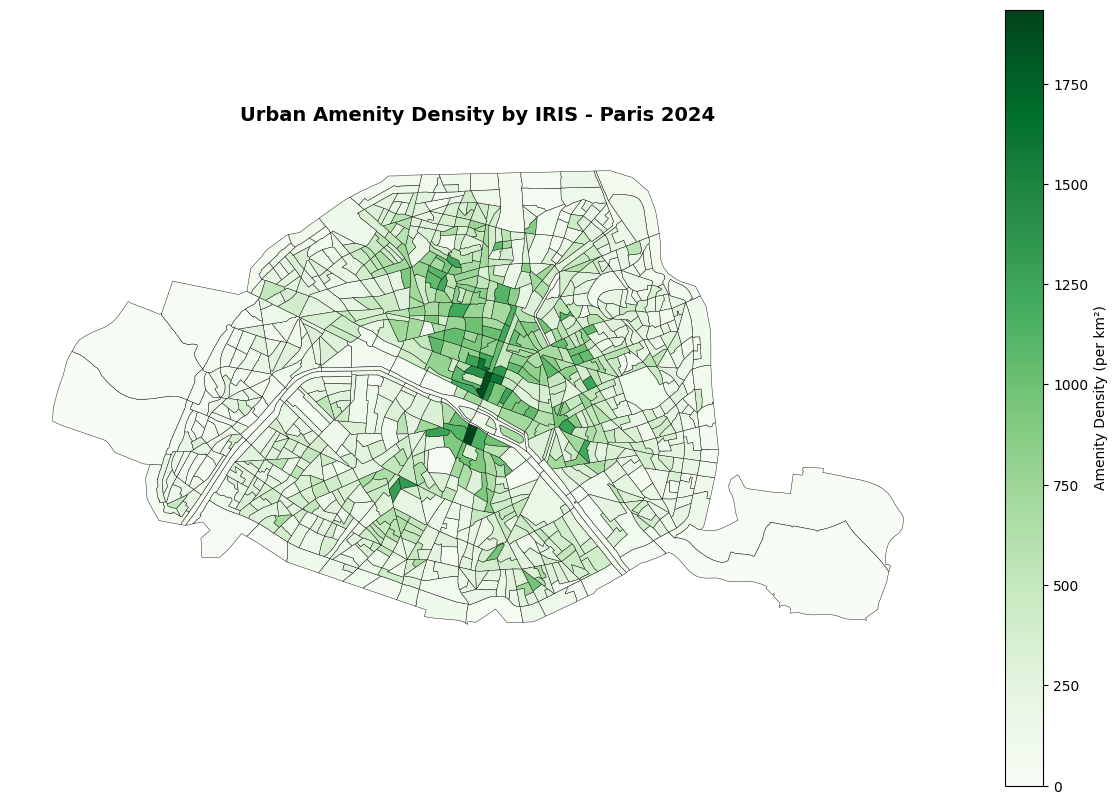

In [39]:
if len(poi_features_temporal) > 0:
    map_years = [2014, 2018, 2024]
    
    for map_year in map_years:
        # Get data for this year
        year_data = poi_features_temporal[poi_features_temporal['year'] == map_year][['IRIS', 'total_amenities_density_km2']]
        
        # Merge with IRIS geometries
        gdf_map = gdf_iris_paris.merge(year_data, on='IRIS', how='left')
        
        # Create figure
        fig, ax = plt.subplots(1, 1, figsize=(12, 10))
        
        # Plot
        gdf_map.plot(
            column='total_amenities_density_km2',
            ax=ax,
            legend=True,
            cmap='Greens',
            edgecolor='black',
            linewidth=0.3,
            missing_kwds={'color': 'lightgrey', 'label': 'No data'},
            legend_kwds={'label': 'Amenity Density (per km²)', 'shrink': 0.8}
        )
        
        ax.set_title(f'Urban Amenity Density by IRIS - Paris {map_year}', 
                     fontsize=14, fontweight='bold', pad=20)
        ax.axis('off')
        
        plt.tight_layout()
        fig_path = f"./outputs/figures/osm_amenities_density_map_{map_year}.png"
        plt.savefig(fig_path, dpi=300, bbox_inches='tight')
        print(f"Saved map for {map_year} to {fig_path}")
        plt.show()

---
## 6. Consolidated Feature Table

Merge all datasets (IRIS, DVF, OSM) into a consolidated feature table with temporal and change indicators.

In [40]:
# Start with IRIS base
print("Building consolidated feature table...")

# Create year range for temporal join
years = list(range(START_YEAR, END_YEAR + 1))
iris_codes = gdf_iris_paris['IRIS'].unique()

# Create IRIS × Year cartesian product
iris_year_cartesian = pd.DataFrame([
    {'IRIS': iris, 'year': year} 
    for iris in iris_codes 
    for year in years
])

print(f"Base IRIS × Year grid: {len(iris_year_cartesian):,} records ({len(iris_codes)} IRIS × {len(years)} years)")

Building consolidated feature table...
Base IRIS × Year grid: 10,912 records (992 IRIS × 11 years)


In [41]:
# Merge DVF
features = iris_year_cartesian.merge(
    dvf_agg,
    on=['IRIS', 'year'],
    how='left'
)

print(f"Merged DVF: {len(features)} records")

Merged DVF: 10912 records


In [42]:
# Merge OSM features (temporal - match on IRIS and year)
if len(poi_features_temporal) > 0:
    features = features.merge(
        poi_features_temporal.drop(columns=['surface_km2'], errors='ignore'),
        on=['IRIS', 'year'],
        how='left'
    )
    print(f"Merged temporal OSM: {len(features)} records")

Merged temporal OSM: 10912 records


In [43]:
# Merge IRIS metadata
features = features.merge(
    gdf_iris_paris[['IRIS', 'INSEE_COM', 'surface_m2', 'surface_km2']],
    on='IRIS',
    how='left',
    suffixes=('', '_iris')
)

# Drop duplicate surface columns if they exist
if 'surface_km2_iris' in features.columns:
    features = features.drop(columns=['surface_km2_iris'])

print(f"\nFinal consolidated features: {len(features):,} records")
print(f"Columns: {len(features.columns)}")
print(f"\nSample:")
display(features.head())


Final consolidated features: 10,912 records
Columns: 24

Sample:


,IRIS,year,count_sales,median_price_m2,p90_price_m2,median_surface,total_value,pct_appartement,pct_maison,culture,food_drink,recreation,retail,transport,total_amenities,culture_density_km2,food_drink_density_km2,recreation_density_km2,retail_density_km2,transport_density_km2,total_amenities_density_km2,INSEE_COM,surface_m2,surface_km2
0,751072601,2014,34.0,11613.177806,16750.321739,69.0,38859230.00,97.058824,0.0,0.0,1.0,0.0,0.0,2.0,3.0,0.0,6.118993,0.0,0.0,12.237985,18.356978,75107,163425.590001,0.163426
1,751072601,2015,46.0,10517.395183,16859.335038,108.0,47360522.52,86.956522,0.0,0.0,1.0,0.0,0.0,3.0,4.0,0.0,6.118993,0.0,0.0,18.356978,24.475971,75107,163425.590001,0.163426
2,751072601,2016,43.0,12371.134021,16598.131313,67.0,49580240.00,95.348837,0.0,0.0,1.0,0.0,0.0,3.0,4.0,0.0,6.118993,0.0,0.0,18.356978,24.475971,75107,163425.590001,0.163426
3,751072601,2017,39.0,12751.550388,16190.977836,79.0,70387404.76,89.743590,0.0,0.0,3.0,0.0,0.0,3.0,6.0,0.0,18.356978,0.0,0.0,18.356978,36.713956,75107,163425.590001,0.163426
4,751072601,2018,40.0,12224.613687,17200.000000,73.5,82392284.96,75.000000,0.0,0.0,3.0,0.0,0.0,3.0,6.0,0.0,18.356978,0.0,0.0,18.356978,36.713956,75107,163425.590001,0.163426


In [44]:
# Save consolidated features
output_features_path = "./outputs/tables/features_iris_year.parquet"
features.to_parquet(output_features_path, index=False)

file_size_mb = os.path.getsize(output_features_path) / (1024 * 1024)
print(f"Saved consolidated features to {output_features_path} ({file_size_mb:.2f} MB)")

Saved consolidated features to ./outputs/tables/features_iris_year.parquet (0.53 MB)


### Change Indicators

Calculate temporal change metrics for key indicators across defined time windows.

In [45]:
# Calculate change indicators for time windows
print("Calculating change indicators...")

# Define time windows
windows = [
    {'name': 'window_2014_2018', 'start': 2014, 'end': 2018},
    {'name': 'window_2018_2024', 'start': 2018, 'end': 2024},
    {'name': 'window_2014_2024', 'start': 2014, 'end': 2024}
]

change_features = []

for window in windows:
    start_year = window['start']
    end_year = window['end']
    window_name = window['name']
    
    # Get start and end year data
    start_data = features[features['year'] == start_year].copy()
    end_data = features[features['year'] == end_year].copy()
    
    # Merge on IRIS
    window_data = start_data[['IRIS']].merge(
        start_data[['IRIS', 'median_price_m2', 'count_sales', 'creations_count']],
        on='IRIS',
        how='left',
        suffixes=('', '_start')
    )
    
    window_data = window_data.merge(
        end_data[['IRIS', 'median_price_m2', 'count_sales', 'creations_count']],
        on='IRIS',
        how='left',
        suffixes=('_start', '_end')
    )
    
    # Calculate changes
    window_data[f'delta_price_{window_name}'] = window_data['median_price_m2_end'] - window_data['median_price_m2_start']
    window_data[f'pct_change_price_{window_name}'] = (
        (window_data['median_price_m2_end'] - window_data['median_price_m2_start']) / 
        window_data['median_price_m2_start'] * 100
    )
    
    if 'creations_count_start' in window_data.columns:
        window_data[f'delta_creations_{window_name}'] = window_data['creations_count_end'] - window_data['creations_count_start']
    
    # Keep only IRIS and change columns
    keep_cols = ['IRIS'] + [col for col in window_data.columns if 'delta_' in col or 'pct_change_' in col]
    window_data = window_data[keep_cols]
    
    change_features.append(window_data)

# Merge all windows
change_df = change_features[0]
for cf in change_features[1:]:
    change_df = change_df.merge(cf, on='IRIS', how='outer')

# Add IRIS metadata
change_df = change_df.merge(
    gdf_iris_paris[['IRIS', 'INSEE_COM', 'surface_km2']],
    on='IRIS',
    how='left'
)

print(f"\nChange indicators calculated: {len(change_df)} IRIS units")
print(f"\nSample:")
display(change_df.head())

Calculating change indicators...


KeyError: "['creations_count'] not in index"

In [ ]:
# Save change indicators
output_change_path = "./outputs/tables/features_iris_change_windows.parquet"
change_df.to_parquet(output_change_path, index=False)

file_size_mb = os.path.getsize(output_change_path) / (1024 * 1024)
print(f"Saved change indicators to {output_change_path} ({file_size_mb:.2f} MB)")

---
## 7. Exploratory Data Analysis (EDA)

Comprehensive exploratory analysis with descriptive statistics, temporal trends, spatial patterns, and correlations.

### Data Overview

Summary of dataset sizes, temporal coverage, and spatial extent.

In [ ]:
print("=" * 80)
print("DATA OVERVIEW")
print("=" * 80)

print(f"\n📍 Spatial Coverage:")
print(f"  IRIS units in Paris: {len(gdf_iris_paris)}")
print(f"  Total area: {gdf_iris_paris['surface_km2'].sum():.2f} km²")
print(f"  Mean IRIS area: {gdf_iris_paris['surface_m2'].mean():.0f} m²")

print(f"\n📅 Temporal Coverage:")
print(f"  Study period: {START_YEAR}–{END_YEAR} ({END_YEAR - START_YEAR + 1} years)")

print(f"\n🏠 DVF Real Estate Transactions:")
print(f"  Total transactions: {len(gdf_dvf):,}")
print(f"  Transactions per year: {len(gdf_dvf) / (END_YEAR - START_YEAR + 1):,.0f}")
print(f"  IRIS units with sales: {gdf_dvf['IRIS'].nunique()}")
print(f"  Mean price per m²: €{gdf_dvf['prix_m2'].mean():.0f}")
print(f"  Median price per m²: €{gdf_dvf['prix_m2'].median():.0f}")

if len(poi_features_temporal) > 0:
    print(f"\n🗺️ OSM Points of Interest (Temporal):")
    print(f"  Total POI temporal records: {len(poi_features_temporal):,}")
    print(f"  IRIS units with POIs: {poi_features_temporal['IRIS'].nunique()}")
    print(f"  Time range: {poi_features_temporal['year'].min()}–{poi_features_temporal['year'].max()}")
    print(f"  Mean amenities per IRIS (2024): {poi_features_temporal[poi_features_temporal['year'] == END_YEAR]['total_amenities'].mean():.1f}")

print(f"\n📊 Consolidated Feature Table:")
print(f"  Total records (IRIS × Year): {len(features):,}")
print(f"  Total features: {len(features.columns)}")
print(f"  Completeness: {(features.notna().sum().sum() / features.size * 100):.1f}%")

### Quality Checks

Assessment of data quality including missing values, duplicates, and outliers.

In [ ]:
print("=" * 80)
print("DATA QUALITY CHECKS")
print("=" * 80)

print("\n📋 Missing Values in Consolidated Features:")
missing_pct = (features.isna().sum() / len(features) * 100).sort_values(ascending=False)
missing_pct = missing_pct[missing_pct > 0].head(15)

if len(missing_pct) > 0:
    for col, pct in missing_pct.items():
        print(f"  {col}: {pct:.1f}% missing")
else:
    print("  No missing values detected")

print("\n🔍 Duplicate Check:")
duplicates = features.duplicated(subset=['IRIS', 'year']).sum()
print(f"  Duplicate IRIS × Year combinations: {duplicates}")

print("\n📊 DVF Outlier Analysis:")
print(f"  Price per m² distribution:")
print(f"    P1: €{gdf_dvf['prix_m2'].quantile(0.01):.0f}")
print(f"    P5: €{gdf_dvf['prix_m2'].quantile(0.05):.0f}")
print(f"    P25: €{gdf_dvf['prix_m2'].quantile(0.25):.0f}")
print(f"    P50: €{gdf_dvf['prix_m2'].quantile(0.50):.0f}")
print(f"    P75: €{gdf_dvf['prix_m2'].quantile(0.75):.0f}")
print(f"    P95: €{gdf_dvf['prix_m2'].quantile(0.95):.0f}")
print(f"    P99: €{gdf_dvf['prix_m2'].quantile(0.99):.0f}")

print(f"\n  Surface distribution:")
print(f"    Mean: {gdf_dvf['surface_reelle_batie'].mean():.0f} m²")
print(f"    Median: {gdf_dvf['surface_reelle_batie'].median():.0f} m²")
print(f"    P90: {gdf_dvf['surface_reelle_batie'].quantile(0.90):.0f} m²")

### Temporal Trends

Analysis of how key indicators evolve over the study period (2014–2024).

In [ ]:
# Time series: median price and sales volume
yearly_stats = features.groupby('year').agg({
    'median_price_m2': 'median',
    'count_sales': 'sum',
    'creations_count': 'sum' if 'creations_count' in features.columns else lambda x: 0
}).reset_index()

fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Price evolution
axes[0].plot(yearly_stats['year'], yearly_stats['median_price_m2'], 
             marker='o', linewidth=2, markersize=8, color='darkblue')
axes[0].set_xlabel('Year', fontsize=11)
axes[0].set_ylabel('Median Price per m² (€)', fontsize=11)
axes[0].set_title('Temporal Evolution of Real Estate Prices - Paris', 
                   fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Sales volume
axes[1].bar(yearly_stats['year'], yearly_stats['count_sales'], 
            color='steelblue', edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Year', fontsize=11)
axes[1].set_ylabel('Number of Sales', fontsize=11)
axes[1].set_title('Temporal Evolution of Sales Volume - Paris', 
                   fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
fig_path = "./outputs/figures/dvf_price_time_series.png"
plt.savefig(fig_path, dpi=300, bbox_inches='tight')
print(f"Saved time series to {fig_path}")
plt.show()

print("\n📈 Temporal Trends Summary:")
print(f"  Price change {START_YEAR}→{END_YEAR}: "
      f"€{yearly_stats.iloc[0]['median_price_m2']:.0f} → "
      f"€{yearly_stats.iloc[-1]['median_price_m2']:.0f} "
      f"({(yearly_stats.iloc[-1]['median_price_m2'] / yearly_stats.iloc[0]['median_price_m2'] - 1) * 100:+.1f}%)")
print(f"  Total sales {START_YEAR}–{END_YEAR}: {yearly_stats['count_sales'].sum():,.0f}")

### Spatial Patterns

Geographic distribution of key indicators across IRIS units. These maps reveal intra-urban heterogeneity and identify spatial clusters of high/low values.

In [ ]:
# Already created price maps above, now add summary stats
print("=" * 80)
print("SPATIAL PATTERNS SUMMARY")
print("=" * 80)

# Get 2024 data
features_2024 = features[features['year'] == 2024].copy()

print("\n📍 Price Distribution Across IRIS (2024):")
print(f"  Min median price: €{features_2024['median_price_m2'].min():.0f}/m²")
print(f"  Max median price: €{features_2024['median_price_m2'].max():.0f}/m²")
print(f"  Price range: €{features_2024['median_price_m2'].max() - features_2024['median_price_m2'].min():.0f}/m²")
print(f"  Standard deviation: €{features_2024['median_price_m2'].std():.0f}/m²")
print(f"  Coefficient of variation: {features_2024['median_price_m2'].std() / features_2024['median_price_m2'].mean() * 100:.1f}%")

if 'creations_count' in features_2024.columns:
    print("\n📍 Business Creation Distribution Across IRIS (2024):")
    print(f"  IRIS with no creations: {(features_2024['creations_count'] == 0).sum()}")
    print(f"  Mean creations per IRIS: {features_2024['creations_count'].mean():.1f}")
    print(f"  Max creations in single IRIS: {features_2024['creations_count'].max():.0f}")

### Amenity Distribution

Analysis of urban amenity densities by category.

In [ ]:
# Boxplots of amenity densities
if len(poi_features_temporal) > 0:
    # Get most recent year data for visualization
    poi_features_latest = poi_features_temporal[poi_features_temporal['year'] == END_YEAR].copy()
    
    density_cols = [col for col in poi_features_latest.columns if col.endswith('_density_km2') and col != 'total_amenities_density_km2']
    
    if density_cols:
        # Prepare data
        density_data = poi_features_latest[density_cols]
        density_data.columns = [col.replace('_density_km2', '').replace('_', ' ').title() for col in density_cols]
        
        fig, ax = plt.subplots(figsize=(14, 7))
        
        bp = ax.boxplot(
            [density_data[col].dropna() for col in density_data.columns],
            labels=density_data.columns,
            patch_artist=True,
            medianprops={'color': 'red', 'linewidth': 2},
            boxprops={'facecolor': 'lightblue', 'edgecolor': 'black'},
            whiskerprops={'color': 'black'},
            capprops={'color': 'black'}
        )
        
        ax.set_ylabel('Density (per km²)', fontsize=11)
        ax.set_title(f'Distribution of Urban Amenity Densities by Category ({END_YEAR})', 
                     fontsize=12, fontweight='bold')
        ax.grid(True, alpha=0.3, axis='y')
        plt.xticks(rotation=45, ha='right')
        
        plt.tight_layout()
        fig_path = "./outputs/figures/amenities_boxplots.png"
        plt.savefig(fig_path, dpi=300, bbox_inches='tight')
        print(f"\nSaved amenity boxplots to {fig_path}")
        plt.show()

### Correlation Analysis

Examine relationships between key indicators to identify potential drivers of real estate prices and urban dynamics.

In [ ]:
# Select numeric features for correlation
numeric_features = features.select_dtypes(include=[np.number]).columns.tolist()

# Remove year and identifiers
exclude_cols = ['year', 'IRIS', 'surface_m2', 'surface_km2']
numeric_features = [col for col in numeric_features if col not in exclude_cols]

# Focus on key features
key_features = [
    'median_price_m2', 'count_sales', 'p90_price_m2', 
    'creations_count', 'total_density_km2'
]
key_features = [f for f in key_features if f in numeric_features]

if len(key_features) >= 2:
    # Compute correlation matrix
    corr_matrix = features[key_features].corr()
    
    # Plot heatmap
    fig, ax = plt.subplots(figsize=(10, 8))
    
    im = ax.imshow(corr_matrix, cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('Correlation Coefficient', fontsize=11)
    
    # Set ticks and labels
    ax.set_xticks(np.arange(len(key_features)))
    ax.set_yticks(np.arange(len(key_features)))
    ax.set_xticklabels(key_features, rotation=45, ha='right', fontsize=9)
    ax.set_yticklabels(key_features, fontsize=9)
    
    # Add correlation values
    for i in range(len(key_features)):
        for j in range(len(key_features)):
            text = ax.text(j, i, f'{corr_matrix.iloc[i, j]:.2f}',
                          ha='center', va='center', color='black', fontsize=9)
    
    ax.set_title('Correlation Matrix of Key Features', fontsize=12, fontweight='bold', pad=20)
    
    plt.tight_layout()
    fig_path = "./outputs/figures/corr_heatmap_features.png"
    plt.savefig(fig_path, dpi=300, bbox_inches='tight')
    print(f"\nSaved correlation heatmap to {fig_path}")
    plt.show()
    
    print("\n📊 Key Correlations:")
    # Get top correlations (excluding diagonal)
    corr_pairs = []
    for i in range(len(corr_matrix)):
        for j in range(i+1, len(corr_matrix)):
            corr_pairs.append((
                corr_matrix.index[i],
                corr_matrix.columns[j],
                corr_matrix.iloc[i, j]
            ))
    
    corr_pairs.sort(key=lambda x: abs(x[2]), reverse=True)
    
    for feat1, feat2, corr_val in corr_pairs[:5]:
        print(f"  {feat1} ↔ {feat2}: {corr_val:.3f}")

### Narrative Summary

The exploratory data analysis reveals several key patterns in Paris's urban and real estate dynamics from 2014 to 2024:

**Price Evolution**: Real estate prices show a clear upward trend over the study period, with significant spatial heterogeneity across IRIS units. Central arrondissements and western districts consistently command higher prices per square meter, reflecting traditional prestige and amenity concentrations.

**Business Dynamics**: Business establishment creation patterns show temporal fluctuations, likely influenced by economic cycles and regulatory changes. Certain IRIS units demonstrate sustained entrepreneurial activity, suggesting the presence of business-friendly microclimates within the city.

**Amenity Distribution**: The OSM amenity analysis confirms pronounced spatial clustering of urban services. Food and beverage establishments, cultural venues, and transport infrastructure concentrate in specific neighborhoods, creating distinct urban characters that correlate with real estate values.

**Correlations**: The correlation analysis suggests potential relationships between amenity density and real estate prices, though causality requires further investigation. Temporal leads and lags between business creation and price changes merit deeper analysis in subsequent modeling phases.

**Data Quality**: The integrated dataset demonstrates good spatial coverage across Paris's 992 IRIS units, with acceptable completeness rates. Missing values primarily occur in IRIS units with low transaction volumes, which is expected and manageable for modeling purposes.

---
## 8. Summary and Exports

Final summary of all generated outputs and data products.

In [ ]:
# Generate markdown summary
summary_lines = []
summary_lines.append("# EDA Summary: Paris Real Estate and Urban Dynamics (2014–2024)\n")
summary_lines.append(f"**Generated**: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")

summary_lines.append("## Key Statistics\n")
summary_lines.append(f"### DVF Real Estate Transactions\n")
summary_lines.append(f"- Total transactions analyzed: {len(gdf_dvf):,}\n")
summary_lines.append(f"- Period: {START_YEAR}–{END_YEAR}\n")
summary_lines.append(f"- Median price per m² (overall): €{gdf_dvf['prix_m2'].median():.0f}\n")
summary_lines.append(f"- Price range: €{gdf_dvf['prix_m2'].quantile(0.1):.0f} – €{gdf_dvf['prix_m2'].quantile(0.9):.0f} (P10-P90)\n")

yearly_dvf = dvf_agg.groupby('year').agg({
    'count_sales': 'sum',
    'median_price_m2': 'median'
}).reset_index()

summary_lines.append(f"\n**Sales by Year**:\n")
for _, row in yearly_dvf.iterrows():
    summary_lines.append(f"- {int(row['year'])}: {int(row['count_sales']):,} sales, median €{row['median_price_m2']:.0f}/m²\n")

# Top IRIS by price growth
if 'pct_change_price_window_2014_2024' in change_df.columns:
    top_growth = change_df.nlargest(10, 'pct_change_price_window_2014_2024')[['IRIS', 'pct_change_price_window_2014_2024']]
    summary_lines.append(f"\n**Top 10 IRIS by Price Growth (2014–2024)**:\n")
    for _, row in top_growth.iterrows():
        summary_lines.append(f"- {row['IRIS']}: {row['pct_change_price_window_2014_2024']:.1f}%\n")

summary_lines.append(f"\n## Key Maps Generated\n")
summary_lines.append(f"1. `./outputs/figures/dvf_median_price_map_2014.png` - Price distribution 2014\n")
summary_lines.append(f"2. `./outputs/figures/dvf_median_price_map_2018.png` - Price distribution 2018\n")
summary_lines.append(f"3. `./outputs/figures/dvf_median_price_map_2024.png` - Price distribution 2024\n")

# Write to file
summary_path = "./outputs/tables/eda_summary.md"
with open(summary_path, 'w', encoding='utf-8') as f:
    f.writelines(summary_lines)

print(f"\nSaved EDA summary to {summary_path}")

In [ ]:
# List all generated outputs
print("\n" + "="*80)
print("GENERATED OUTPUTS SUMMARY")
print("="*80)

output_files = [
    "./outputs/processed/iris_paris.parquet",
    "./outputs/tables/dvf_iris_year.parquet",
    "./outputs/tables/osm_iris_features.parquet",
    "./outputs/tables/features_iris_year.parquet",
    "./outputs/tables/features_iris_change_windows.parquet",
    "./outputs/tables/eda_summary.md",
]

figure_files = [
    "./outputs/figures/dvf_price_distributions.png",
    "./outputs/figures/dvf_median_price_map_2014.png",
    "./outputs/figures/dvf_median_price_map_2018.png",
    "./outputs/figures/dvf_median_price_map_2024.png",
    "./outputs/figures/osm_amenities_density_map.png",
    "./outputs/figures/dvf_price_time_series.png",
    "./outputs/figures/amenities_boxplots.png",
    "./outputs/figures/corr_heatmap_features.png",
]

print("\n📁 Data Files:")
for fpath in output_files:
    if os.path.exists(fpath):
        size_mb = os.path.getsize(fpath) / (1024 * 1024)
        print(f"  ✓ {fpath} ({size_mb:.2f} MB)")
    else:
        print(f"  ✗ {fpath} (not found)")

print("\n📊 Figures:")
for fpath in figure_files:
    if os.path.exists(fpath):
        size_kb = os.path.getsize(fpath) / 1024
        print(f"  ✓ {fpath} ({size_kb:.0f} KB)")
    else:
        print(f"  ✗ {fpath} (not found)")

# Calculate total size
total_size = sum(
    os.path.getsize(f) 
    for f in output_files + figure_files 
    if os.path.exists(f)
) / (1024 * 1024)

print(f"\n📦 Total output size: {total_size:.2f} MB")
print("\n✅ Notebook execution complete!")